In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pickle
import pygenstability as pgs

from matplotlib.pyplot import figure
from pygenstability import plotting
from scipy.linalg import block_diag

from msfiltration import MCF

In [2]:
root_fig = '/home/tc/OneDrive/Software/MSFiltration/paper/figures/'
plt.rcParams.update({'font.size': 20})

# Construct multiscale stochastic block model (mSBM)

In [3]:
def block(n, th, rng):
    A = rng.uniform(0, 1, (n, n))
    A[A < th] = 0.0
    A[A > th] = 1.0
    A = (A + A.T) / 2
    return A


# define size and strength of multiscale structure
n0 = 270
th0 = 0.995

n1 = 3
th1 = 0.95

n2 = 9
th2 = 0.8

n3 = 27
th3 = 0.2

# construct adjacency matrix
rng = np.random.RandomState(42)
A = block(n0, th0, rng)
A += block_diag(*[block(int(n0 / n1), th1, rng) for i in range(n1)])
A += block_diag(*[block(int(n0 / n2), th2, rng) for i in range(n2)])
A += block_diag(*[block(int(n0 / n3), th3, rng) for i in range(n3)])

# binarized
A[A > 0] = 1

# remove self-loops
A -= np.diag(np.diag(A))

Graph with 270 nodes and 3473 edges


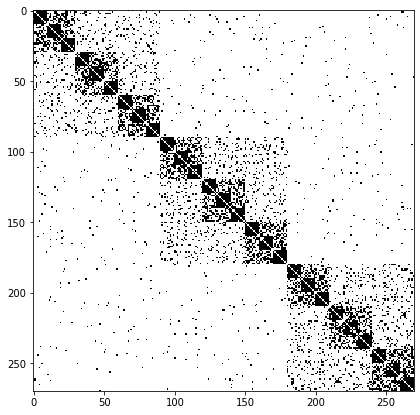

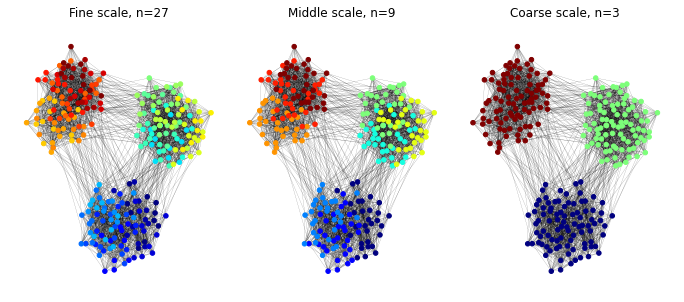

In [4]:
# plot matrix
plt.figure(figsize=(8, 7))
plt.imshow(A, interpolation="nearest",cmap='binary')
plt.savefig(root_fig +'SBM_adjacency_matrix.pdf', bbox_inches='tight')

# Multiscale structure
coarse_scale_id = np.zeros(n0)
middle_scale_id = np.zeros(n0)
fine_scale_id = np.zeros(n0)

for i in range(n1):
    coarse_scale_id[(i * n0 // n1) : ((i + 1) * n0 // n1)] = i

for i in range(n2):
    middle_scale_id[(i * n0 // n2) : ((i + 1) * n0 // n2)] = i

for i in range(n3):
    fine_scale_id[(i * n0 // n3) : ((i + 1) * n0 // n3)] = i

# Create nx graph
G = nx.from_numpy_array(A)

# Compute spring layout
pos = nx.layout.spring_layout(G, seed=2)

# Plot multiscale graph structure
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
fig.subplots_adjust(hspace=0.4, wspace=0)


nx.draw(
    G,
    ax=axes[0],
    pos=pos,
    node_size=20,
    arrows=False,
    width=0.1,
    node_color=fine_scale_id,
    cmap="jet",
)
axes[0].set(title=r"Fine scale, n=27")

nx.draw(
    G,
    ax=axes[1],
    pos=pos,
    node_size=20,
    arrows=False,
    width=0.1,
    node_color=middle_scale_id,
    cmap="jet",
)
axes[1].set(title=r"Middle scale, n=9")

nx.draw(
    G,
    ax=axes[2],
    pos=pos,
    node_size=20,
    arrows=False,
    width=0.1,
    node_color=coarse_scale_id,
    cmap="jet",
)
axes[2].set(title=r"Coarse scale, n=3")

print(G)

In [5]:
root_fig = '/home/tc/OneDrive/Software/MSFiltration/paper/figures/'
plt.rcParams.update({'font.size': 20})

In [6]:
np.unique(A)

array([0., 1.])

# Apply MS analysis


In [7]:
# Set MS parameters
n_scale = 200
min_scale = -1.5
max_scale = 0.5

In [8]:
# # Run MS analysis
# MS_results = pgs.run(A,min_scale= min_scale,max_scale= max_scale,n_scale= n_scale,n_workers=4, constructor="continuous_normalized")

In [9]:
# Load data (deserialize)
with open("mSBM_MS_results.pkl", 'rb') as handle:
    MS_results = pickle.load(handle)

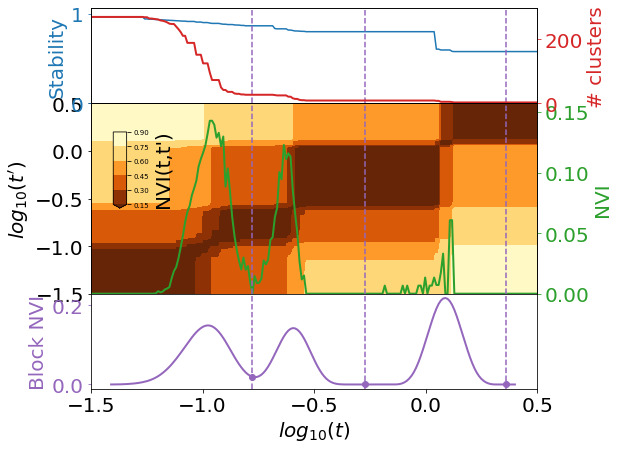

In [10]:
figure(figsize=(8, 7))
plotting.plot_scan(MS_results)
plt.show()

NameError: name 'selected_scales' is not defined

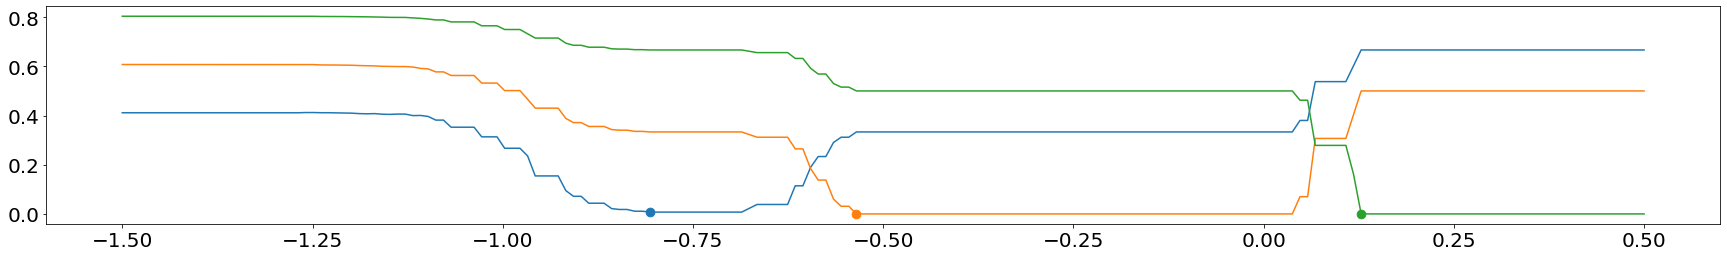

In [25]:
from pygenstability.pygenstability import evaluate_NVI

# compare MS partitions to ground truth with NVI
NVI_scores_fine = np.array(
    [
        evaluate_NVI([0, i], [fine_scale_id] + MS_results["community_id"])
        for i in range(1, n_scale + 1)
    ]
)
NVI_scores_middle = np.array(
    [
        evaluate_NVI([0, i], [middle_scale_id] + MS_results["community_id"])
        for i in range(1, n_scale + 1)
    ]
)
NVI_scores_coarse = np.array(
    [
        evaluate_NVI([0, i], [coarse_scale_id] + MS_results["community_id"])
        for i in range(1, n_scale + 1)
    ]
)



# # plot lower bound
fig, ax = plt.subplots(1, figsize=(30, 4))
# ax.axhline(0, c="k", ls="--")

# plot NVI scores
ax.plot(log_scales, NVI_scores_fine, label="Fine")
ax.plot(log_scales, NVI_scores_middle, label="Medium")
ax.plot(log_scales, NVI_scores_coarse, label="Coarse")

# plot minima of NVI scores
ax.scatter(
    log_scales[np.argmin(NVI_scores_fine)], NVI_scores_fine.min(), marker=".", s=300
)
ax.scatter(
    log_scales[np.argmin(NVI_scores_middle)],
    NVI_scores_middle.min(),
    marker=".",
    s=300,
)
ax.scatter(
    log_scales[np.argmin(NVI_scores_coarse)],
    NVI_scores_coarse.min(),
    marker=".",
    s=300,
)


for i in range(len(selected_scales)):
    if i == 0:
        ax.axvline(
            x=selected_scales[i],
            ls="--",
            color="Magenta",
            label="MS Selection",
        )
    else:
        ax.axvline(x=selected_scales[i], ls="--", color="Magenta")

for i in range(len(msf.optimal_scales)):
    if i == 0:
        ax.axvline(
            x=log_scales[msf.optimal_scales[i]],
            ls=":",
            color="Cyan",
            label="MCF Selection",
        )
    else:
        ax.axvline(x=log_scales[msf.optimal_scales[i]], ls=":", color="Cyan")

ax.set(xlabel=r"$log_{10}(t)$", ylabel="NVI")  # yticks = [0.2,0.4,0.6,0.8] )

ax.legend(loc=3)

# plt.savefig(root_fig +'SBM_NVI_Comparison.pdf', dpi=fig.dpi,bbox_inches='tight')

In [29]:
np.where(NVI_scores_fine==NVI_scores_fine.min())

(array([69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]),)

In [30]:
np.where(NVI_scores_middle==NVI_scores_middle.min())

(array([ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
        109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
        122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
        135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
        148, 149, 150, 151, 152, 153]),)

# Apply MCF

In [11]:
partitions = MS_results["community_id"]
log_scales = np.log10(MS_results['scales'])

In [12]:
n_partitions = len(partitions)
n_nodes = len(partitions[0])
partitions_matrix = np.zeros((n_nodes,n_partitions))

for i in range(0,n_partitions):
    partitions_matrix[:,i] = partitions[i]

partitions_matrix = np.asarray(partitions_matrix, dtype="int")

np.savetxt("mSBM_Partitions.csv", partitions_matrix.astype(int), fmt='%i', delimiter=',')

In [13]:
# initialise MCF object
mcf = MCF()
mcf.load_data(partitions,log_scales)

# build filtration and compute PH
mcf.build_filtration()
mcf.compute_persistence()

Constructing filtration with GUDHI ...


100%|██████████| 200/200 [00:07<00:00, 25.07it/s]


Computing persistence with GUDHI ... 


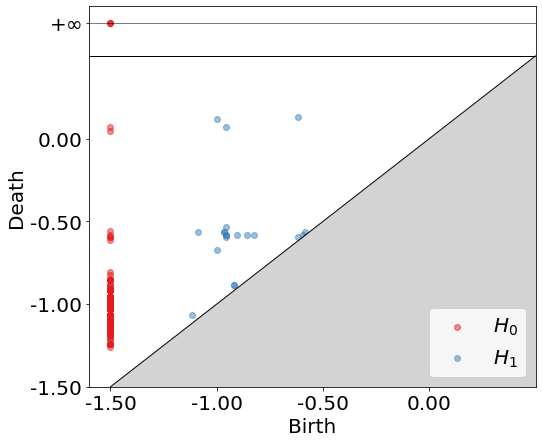

In [19]:
# Plot persistence diagram
ax = mcf.plot_persistence_diagram()
plt.savefig(root_fig +'mSBM_PD.pdf', dpi=fig.dpi,bbox_inches='tight')

In [15]:
from msfiltration.measures import compute_persistent_hierarchy, compute_persistent_conflict, compute_beta_0, compute_partition_size, compute_birth_count, compute_death_count

In [16]:
betti_numbers = np.zeros((n_partitions,3))
for m in range((n_partitions)):
    betti_numbers[m] = mcf.filtration_gudhi.persistent_betti_numbers(log_scales[m],log_scales[m])


betti_0 = betti_numbers[:,0]
betti_1 = betti_numbers[:,1]
betti_2 = betti_numbers[:,2]

s_partitions = compute_partition_size(mcf)

h = betti_0/s_partitions

h_bar = np.mean(h)
print("Average persistent hierarchy:", np.around(h_bar,3))

total_1 = np.cumsum(compute_birth_count(mcf, 1))
resolved_1 = np.cumsum(compute_death_count(mcf, 1)[:-1])

b_1 = compute_birth_count(mcf, 1)
d_1 = compute_death_count(mcf, 1)[:-1]

total_2 = np.cumsum(compute_birth_count(mcf, 2))
resolved_2 = np.cumsum(compute_death_count(mcf, 2)[:-1])

b_2 = compute_birth_count(mcf, 2)
d_2 = compute_death_count(mcf, 2)[:-1]

c_1 = b_1 - d_1
c_2 = b_2 - d_2
c = c_1 + c_2

Average persistent hierarchy: 0.731


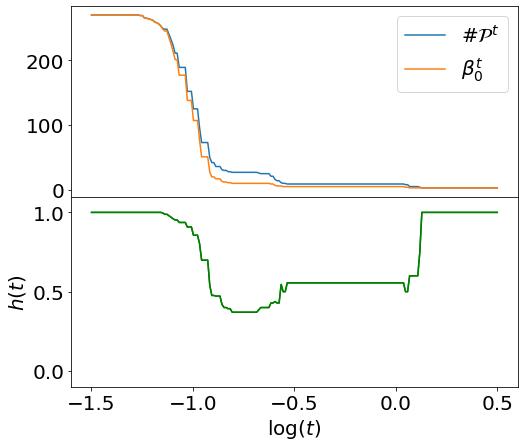

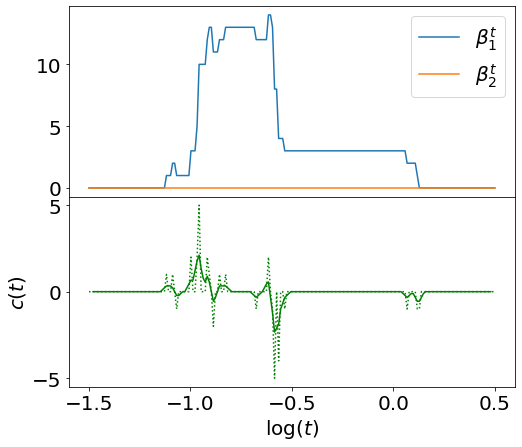

In [18]:
fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]
ax1.plot(log_scales,s_partitions, label = r'$\#\mathcal{P}^t$')
ax1.plot(log_scales,betti_numbers[:,0], label = r'$\beta_0^t$')
ax1.set(xticks=[])

ax1.legend()

ax2.plot(log_scales,compute_persistent_hierarchy(mcf), label = r'$h(t)$',c='green')
ax2.plot(log_scales,h, label = r'$h(t)$',c='green')
ax2.set_ylabel(r'$h(t)$')
ax2.set(xlabel=r'$\log(t)$',ylim=(-0.1,1.1))
plt.savefig(root_fig +'mSBM_hierarchy.pdf', dpi=fig.dpi,bbox_inches='tight')

import pandas as pd

def moving_average(x, w):
    return np.roll(
        np.asarray(pd.Series(x).rolling(window=w, win_type="triang").mean()),
        -int(w / 2),
    )

fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(log_scales,betti_1, label = r'$\beta_1^t$')
ax1.plot(log_scales,betti_2, label = r'$\beta_2^t$')

ax1.set(xticks=[])

ax1.legend()
ax2.plot(log_scales,c,c='green',ls=":")
ax2.plot(log_scales,moving_average(c,5),c='green')
ax2.set_ylabel(r'$c(t)$')#, color="green")
ax2.set(xlabel=r'$\log(t)$')#,ylim=(-0.1,1.1))
plt.savefig(root_fig +'mSBM_conflict.pdf', dpi=fig.dpi,bbox_inches='tight')